<a href="https://colab.research.google.com/github/JP12468/CRmap/blob/main/CRmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

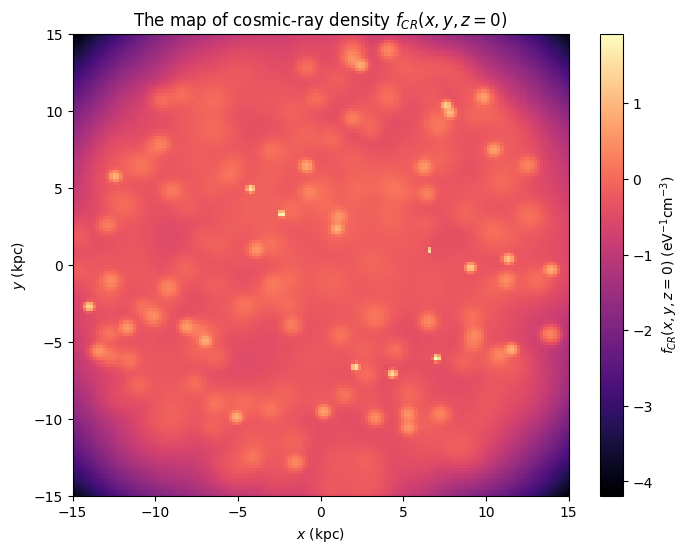

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit, device_put

# Constants
R = 15  # kpc
L = 4   # kpc
z0 = 0
kappa = 4.429 * 1e-5
Q_E = 1
# t_max = L**2 / (2*kappa)  # τ_max = L^2 / (2κ)
t_max = 5 * 10**4
N_sources = int(0.03 * t_max)

# Initialize random number generator
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample points (x0, y0) inside a circle of radius R
theta = random.uniform(key_theta, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key_r, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample time t0 in the interval (0, τ_max)
t0 = random.uniform(key_t, (N_sources,), minval=0, maxval=t_max)

# Spatial grid
grid_size = 150
x_grid = jnp.linspace(-R, R, grid_size)
y_grid = jnp.linspace(-R, R, grid_size)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')

# Optimized 3D Green's function
@jit
def G(t, x, y, x0, y0, t0, kappa_E):
    tau = jnp.maximum(t - t0, 1e-6)  # Ensure tau > 0
    n_values = jnp.arange(-10, 11)  # Reduce number of n terms for speed
    zn = 2 * n_values * L + (-1) ** n_values * z0
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa_E * tau)
    psi_n = ((-1) ** n_values * Q_E / ((4 * jnp.pi * kappa_E * tau) ** (3 / 2))) * jnp.exp(exponent)
    return jnp.sum(psi_n)

# Vectorize over (x, y)
G_vmap = jit(vmap(G, in_axes=(None, 0, 0, None, None, None, None), out_axes=0))

# Compute cosmic-ray density f_CR
@jit
def compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current):
    def single_source_contribution(x, y, x0, y0, t0):
        return G_vmap(t_current, x, y, x0, y0, t0, kappa)

    # Batch processing over sources
    batch_size = 1000
    f_CR_total = jnp.zeros(x_mesh.ravel().shape)

    for i in range(0, len(x0), batch_size):
        f_CR_partial = vmap(single_source_contribution, in_axes=(None, None, 0, 0, 0))(
            x_mesh.ravel(), y_mesh.ravel(), x0[i:i+batch_size], y0[i:i+batch_size], t0[i:i+batch_size]
        )
        f_CR_total += jnp.sum(f_CR_partial, axis=0)

    return f_CR_total.reshape(x_mesh.shape)

# Put data on GPU
x_mesh, y_mesh = device_put((x_mesh, y_mesh))
x0, y0, t0 = device_put((x0, y0, t0))

# Compute f_CR on GPU
t_current = t_max
f_CR = compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current)

plt.figure(figsize=(8, 6))

# Use imshow instead of contourf
plt.imshow(jnp.log10(jnp.nan_to_num(f_CR)).T, origin="lower", extent=[-15, 15, -15, 15], cmap='magma', aspect='auto')  # , vmin=30, vmax=34.5

# Add colorbar
plt.colorbar(label='$f_{CR}(x,y,z=0)$ (eV$^{-1}$cm$^{-3}$)')

# Labels and title
plt.xlabel('$x$ (kpc)')
plt.ylabel('$y$ (kpc)')
plt.title('The map of cosmic-ray density $f_{CR}(x,y,z=0)$')

# Show plot
plt.show()

Cosmic Ray Density at Earth (x=8.5, y=0):
  E = 1.0e+13 eV : f_CR = 6.079e-30 eV$^-1$cm$^-3
  E = 1.0e+14 eV : f_CR = 1.876e-32 eV$^-1$cm$^-3
  E = 1.0e+15 eV : f_CR = 3.703e-35 eV$^-1$cm$^-3


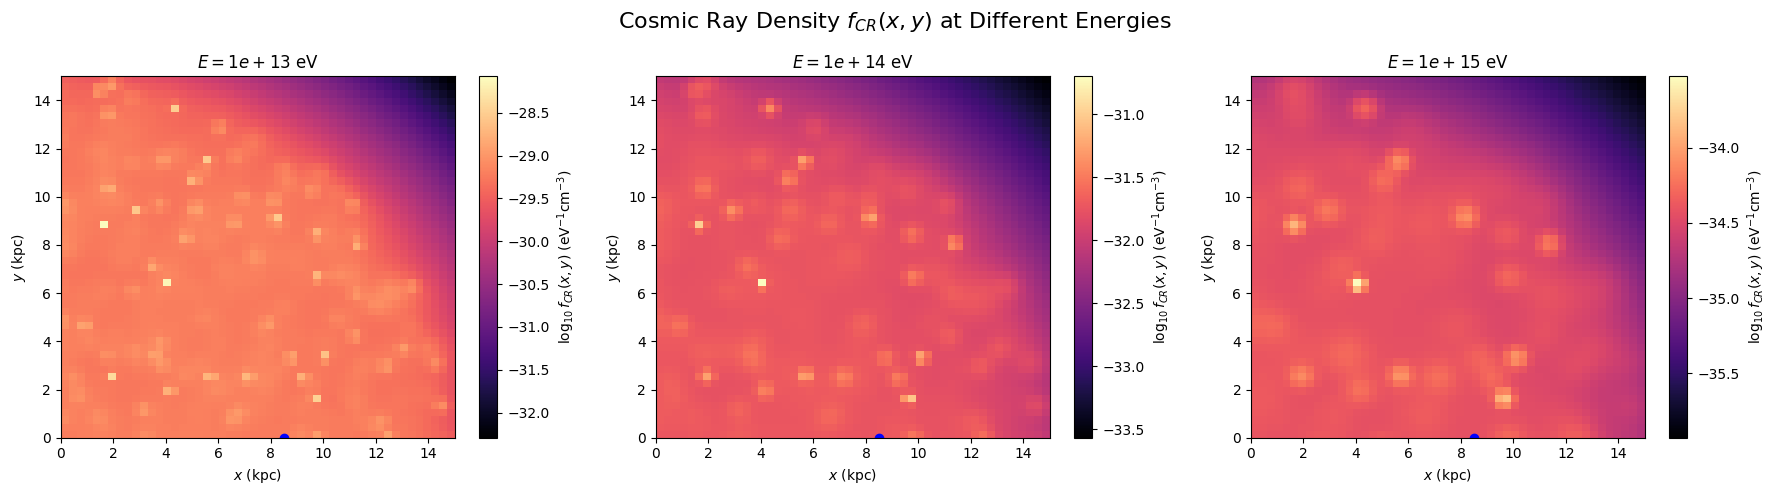

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit
from jax.scipy.ndimage import map_coordinates
import jax
jax.config.update("jax_enable_x64", True)

# Constants
R = 15.0  # kpc
L = 4.0   # kpc
z0 = 0.0
t_max = 1.0e6 # yr
N_sources = int(0.03 * t_max)  # Increased number of sources

# Random number generator
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample (x0, y0) in a circular disk
theta = random.uniform(key_theta, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key_r, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample t0 in (0, t_max)
t0 = random.uniform(key_t, (N_sources,), minval=0, maxval=t_max)

# Grid setup
grid_size = 50
x_grid = jnp.linspace(0.0, R, grid_size)
y_grid = jnp.linspace(0.0, R, grid_size)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')

# Flatten mesh grids for vectorization
x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()

# Diffusion coefficient kappa(E)
def kappa(E):
    kappa_0 = 3.3e-8  # kpc^2 / yr (diffusion coefficient constant)
    m_p_c2 = 0.938e9    # Proton rest energy in eV
    beta = 1.0  # Given in the problem


    # Calculate kappa(E) based on energy E in eV
    x = E / m_p_c2
    kappa_E = kappa_0 * beta * jnp.sqrt(jnp.sqrt(x**2 - 1))

    return kappa_E

# Adjust source spectrum Q(E)
def Q(E):
    alpha = 4.23 # The index of the source spectra
    xi_CR = 0.087  # Convert percentage to fraction
    E_SNR = 6.242e62  # in eV, from 10^51 erg
    m_p_c2 = 0.938e9  # Proton rest energy in eV
    Lambda = 4.111  # Normalization constant
    beta = 1.0  # Given in the problem

    x = E / m_p_c2
    Q_E = (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda * beta) * (jnp.sqrt(x**2 - 1)) ** (2 - alpha)

    return Q_E

# Green's function G
@jit
def G(x, y, x0, y0, t0, t, E):
    tau = jnp.maximum(t - t0, 1e-6)  # Ensure tau > 0
    n_values = jnp.arange(-50, 51)
    zn = 2 * n_values[:, None] * L + (-1) ** n_values[:, None] * z0  # Shape (101, 1)

    # Compute exponent term with broadcasting
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa(E) * tau)
    psi_n = ((-1) ** n_values[:, None] * Q(E) / ((4 * jnp.pi * kappa(E) * 3.086e21 **2 * tau) ** (3 / 2))) * jnp.exp(exponent)

    return jnp.sum(psi_n, axis=0)  # Sum over n to collapse dimension

# Vectorized G over (x, y)
G_vmap = jit(vmap(G, in_axes=(None, None, 0, 0, 0, None, None), out_axes=0))

# Precompute G values efficiently
@jit
def precompute_G(x_flat, y_flat, x0, y0, t0, t_current, E):
    f_CR_total = vmap(G, in_axes=(None, None, 0, 0, 0, None, None))(
        x_flat, y_flat, x0, y0, t0, t_current, E)
    return jnp.sum(f_CR_total, axis=0).reshape(grid_size, grid_size)

# JAX-compatible interpolation of G
def interpolate_G(x_mesh, y_mesh, x_grid, y_grid, f_CR):
    x_indices = (x_mesh - x_grid[0]) / (x_grid[-1] - x_grid[0]) * (grid_size - 1)
    y_indices = (y_mesh - y_grid[0]) / (y_grid[-1] - y_grid[0]) * (grid_size - 1)
    x_indices = jnp.clip(x_indices, 0, grid_size - 1)
    y_indices = jnp.clip(y_indices, 0, grid_size - 1)
    return map_coordinates(f_CR, [x_indices, y_indices], order=1)

# Compute precomputed G values
t_current = t_max
E_values = [1e13, 1e14, 1e15]
f_CR_list = []

for E in E_values:
    f_CR_E = precompute_G(x_flat, y_flat, x0, y0, t0, t_current, E)
    f_CR_list.append(f_CR_E)

# Earth's coordinates
x_earth = 8.5  # kpc
y_earth = 0.0  # kpc

# Find closest grid indices
ix = jnp.argmin(jnp.abs(x_grid - x_earth))
iy = jnp.argmin(jnp.abs(y_grid - y_earth))

# Print CR density at Earth
print("Cosmic Ray Density at Earth (x=8.5, y=0):")
for E, f_CR_E in zip(E_values, f_CR_list):
    f_val = f_CR_E[ix, iy]
    print(f"  E = {E:.1e} eV : f_CR = {f_val:.3e} eV$^{-1}$cm$^{-3}")

# Plot f_CR(x, y) maps for each energy
fig, axs = plt.subplots(1, len(E_values), figsize=(18, 5))
for i, (E, f_CR_E) in enumerate(zip(E_values, f_CR_list)):
    im = axs[i].imshow(
        jnp.log10(jnp.nan_to_num(f_CR_E)).T,
        origin="lower",
        extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
        cmap='magma',
        aspect='auto'
    )
    axs[i].plot(x_earth, y_earth, 'bo', label='Earth')
    axs[i].set_title(f'$E = {E:.0e}$ eV')
    axs[i].set_xlabel('$x$ (kpc)')
    axs[i].set_ylabel('$y$ (kpc)')
    fig.colorbar(im, ax=axs[i], label='$\log_{10} \psi(x,y)$ (eV$^{-1}$cm$^{-3}$)')

plt.suptitle("Cosmic Ray Density $f_{CR}(x,y)$ at Different Energies", fontsize=16)
plt.tight_layout()
plt.show()

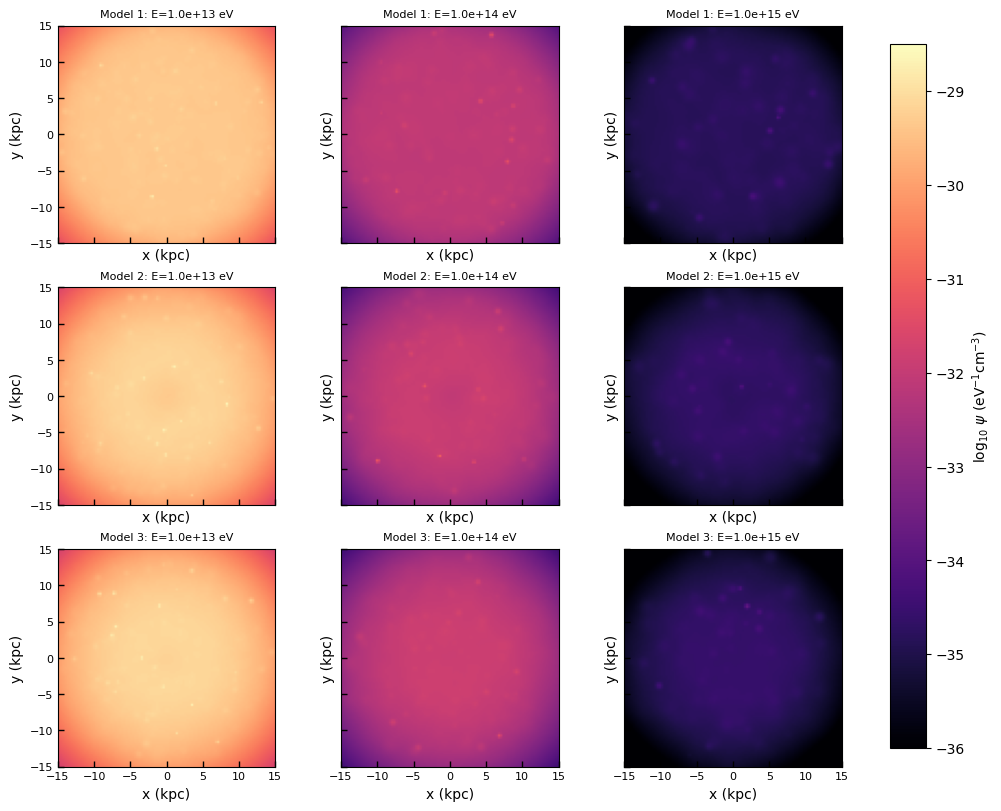

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from jax import random

jax.config.update("jax_enable_x64", True)

kpc = 3.086e21
year = 3.154e7
m_p_c2 = 0.938e9
E_values = jnp.array([1e13, 1e14, 1e15], dtype=jnp.float64)
L_kpc = 4.0
L = L_kpc * kpc
R_kpc = 15.0
R = R_kpc * kpc
Nmax = 10
R_grid = 100

x_grid = jnp.linspace(-R_kpc, R_kpc, R_grid, dtype=jnp.float64) * kpc
y_grid = jnp.linspace(-R_kpc, R_kpc, R_grid, dtype=jnp.float64) * kpc
xx, yy = jnp.meshgrid(x_grid, y_grid, indexing="ij")

def Q_E(E):
    alpha = 4.23
    xi_CR = 0.087
    E_SNR = 6.242e62
    Lambda = 4.111
    beta = 1.0
    x = E / m_p_c2
    return (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda * beta) * (jnp.sqrt(x**2 - 1)) ** (2 - alpha)

def kappa_E(E):
    kappa_0 = 3.3e-8
    beta = 1.0
    x = E / m_p_c2
    kappa_val = kappa_0 * beta * jnp.sqrt(jnp.sqrt(x**2 - 1))
    return kappa_val * (kpc**2) / year

def green_function_sum(E, x, y, sources, tau):
    D = kappa_E(E)
    Q = Q_E(E)
    N_sources = sources.shape[0]
    Nx, Ny = x.shape
    coef = Q / ((4 * jnp.pi * D * tau) ** 1.5)
    result = jnp.zeros((Nx, Ny), dtype=jnp.float64)
    for n in range(-Nmax, Nmax + 1):
        sign = (-1)**n
        z_img = sign * sources[:, 2] + 2 * n * L
        dx = x[None, :, :] - sources[:, 0:1, None]
        dy = y[None, :, :] - sources[:, 1:2, None]
        dz = z_img[:, None, None]
        exponent = -(dx**2 + dy**2 + dz**2) / (4 * D * tau[:, None, None])
        G = coef[:, None, None] * jnp.exp(exponent)
        result += sign * jnp.sum(G, axis=0)
    return result

def psi_batch(E, x, y, sources, tau, batch_size=1000):
    N = sources.shape[0]
    result = jnp.zeros_like(x)
    for i in range(0, N, batch_size):
        s_batch = sources[i:i+batch_size]
        tau_batch = tau[i:i+batch_size]
        result += green_function_sum(E, x, y, s_batch, tau_batch)
    return result

def sample_from_pdf(pdf, R_max, N_sources):
    R_vals = np.linspace(0.01, R_max, R_grid)
    p_vals = pdf(R_vals)
    p_vals /= np.sum(p_vals)
    cdf = np.cumsum(p_vals)
    cdf /= cdf[-1]
    rand = np.random.rand(N_sources)
    R_samples = np.interp(rand, cdf, R_vals)
    theta_samples = 2 * np.pi * np.random.rand(N_sources)
    x_samples = R_samples * np.cos(theta_samples)
    y_samples = R_samples * np.sin(theta_samples)
    return x_samples, y_samples

def generate_sources(model_id, key, N_sources):
    zkey, rkey = random.split(key)
    z = L * (2 * random.uniform(zkey, (N_sources,), dtype=jnp.float64) - 1)

    R_max = R_kpc
    R_sun = 8.5
    alpha_case = 2.35
    beta_case = 3.56
    A_sine = 1.96
    R0_sine = 17.2
    theta0_sine = 0.08
    beta_sine = 0.13

    if model_id == 1:
        def f_homo_integrand(R):
            return 2 * np.pi * R

        I_homo, _ = quad(f_homo_integrand, 0, R_max)
        def f_homo(R):
            C = 1 / I_homo
            return np.where(R > 0, C * 2 * np.pi * R, 0)

        subkey_np = int(rkey[0])
        np.random.seed(subkey_np)
        x_homo, y_homo = sample_from_pdf(f_homo, R_max, N_sources)
        x = jnp.array(x_homo) * kpc
        y = jnp.array(y_homo) * kpc

    elif model_id == 2:
        def f_case_integrand(R):
            return (R / R_sun) ** alpha_case * np.exp(-beta_case * (R - R_sun) / R_sun) * 2 * np.pi * R

        I_case, _ = quad(f_case_integrand, 0, R_max)
        def f_case(R):
            C = 1 / I_case
            return np.where(R > 0, C * f_case_integrand(R), 0)

        subkey_np = int(rkey[0])
        np.random.seed(subkey_np)
        x_case, y_case = sample_from_pdf(f_case, R_max, N_sources)
        x = jnp.array(x_case) * kpc
        y = jnp.array(y_case) * kpc

    elif model_id == 3:
        def f_sine_integrand(R):
            val = A_sine * np.sin(np.pi * R / R0_sine + theta0_sine) * np.exp(-beta_sine * R)
            return np.where(val > 0, val * 2 * np.pi * R, 0)

        I_sine, _ = quad(f_sine_integrand, 0, R_max)
        def f_sine(R):
            C = 1 / I_sine
            val = A_sine * np.sin(np.pi * R / R0_sine + theta0_sine) * np.exp(-beta_sine * R)
            return np.where(val > 0, C * val * 2 * np.pi * R, 0)

        subkey_np = int(rkey[0])
        np.random.seed(subkey_np)
        x_sine, y_sine = sample_from_pdf(f_sine, R_max, N_sources)
        x = jnp.array(x_sine) * kpc
        y = jnp.array(y_sine) * kpc

    return jnp.stack([x, y, z], axis=-1)

key = random.PRNGKey(0)
fig, axes = plt.subplots(3, 3, figsize=(10, 8), constrained_layout=True, sharex=True, sharey=True)

vmin, vmax = -36, -28.5
ims = []

for model_id in [1, 2, 3]:
    for i, E in enumerate(E_values):
        D = kappa_E(E)
        t_max = (L**2) / (2 * D)
        t_max_year = t_max / year

        N_sources = int(0.03 * t_max_year)
        if N_sources < 1:
            N_sources = 1

        subkey, key = random.split(key)
        sources = generate_sources(model_id, subkey, N_sources)
        tau_i_year = random.uniform(subkey, shape=(N_sources,), minval=0.0, maxval=float(t_max_year), dtype=jnp.float64)
        tau_i = tau_i_year * year

        psi = psi_batch(E, xx, yy, sources, tau_i)
        log_psi = jnp.log10(psi)

        ax = axes[model_id - 1, i]
        im = ax.imshow(log_psi.T, extent=[-R_kpc, R_kpc, -R_kpc, R_kpc], origin='lower',
                       cmap='magma', vmin=vmin, vmax=vmax)
        ax.tick_params(axis='both', which='both', direction='in', length=4, width=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=7))
        ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=7))
        ax.tick_params(labelsize=8)

        ax.set_title(f"Model {model_id}: E={E:.1e} eV", fontsize=8)
        ax.set_xlabel("x (kpc)")
        ax.set_ylabel("y (kpc)")
        ims.append(im)

cbar = fig.colorbar(ims[0], ax=axes, shrink=0.95)
cbar.set_label(r"$\log_{10} \, \psi$ (eV$^{-1}$cm$^{-3}$)", fontsize=10)
cbar.ax.tick_params(labelsize=10)


plt.show()

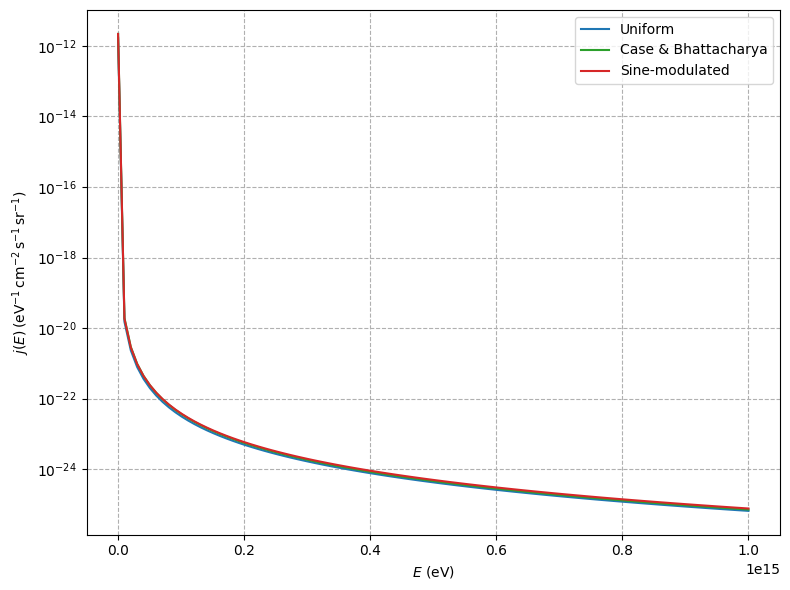

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import random
from scipy.integrate import quad

jax.config.update("jax_enable_x64", True)

# Constants
kpc = 3.086e21
year = 3.154e7
m_p_c2 = 0.938e9  # eV
L_kpc = 4.0
L = L_kpc * kpc
R_kpc = 15.0
R = R_kpc * kpc

# Spatial location (Earth)
x_obs = 8.5 * kpc
y_obs = 0.0

E_values = jnp.linspace(1e10, 1e15, 100, dtype=jnp.float64)

# Functions
def Q_E(E):
    alpha = 4.23
    xi_CR = 0.087
    E_SNR = 6.242e62
    Lambda = 4.111
    beta = 1.0
    x = E / m_p_c2
    return (xi_CR * E_SNR) / ((m_p_c2)**2 * Lambda * beta) * (jnp.sqrt(x**2 - 1))**(2 - alpha)

def kappa_E(E):
    kappa_0 = 3.3e-8
    beta = 1.0
    x = E / m_p_c2
    return kappa_0 * beta * jnp.sqrt(jnp.sqrt(x**2 - 1)) * (kpc**2) / year

def v(E):  # E in eV
    c = 3e10  # cm/s
    m_p_c2 = 0.938e9  # eV
    return c * np.sqrt(1 - (m_p_c2 / E)**2)

Nmax = 10
def green_sum(E, x, y, sources, tau):
    D = kappa_E(E)
    Q = Q_E(E)
    coef = Q / ((4 * jnp.pi * D * tau) ** 1.5)
    result = 0.0
    for n in range(-Nmax, Nmax + 1):
        sign = (-1)**n
        z_img = sign * sources[:, 2] + 2 * n * L
        dx = x - sources[:, 0]
        dy = y - sources[:, 1]
        dz = z_img
        r2 = dx**2 + dy**2 + dz**2
        G = coef * jnp.exp(-r2 / (4 * D * tau))
        result += sign * jnp.sum(G)
    return result

def j_CR_at_point(E, sources, tau, x, y):
    psi = green_sum(E, x, y, sources, tau)  # unit: eV^-1 cm^-3
    return (v(E) / (4 * jnp.pi)) * psi  # unit: eV^-1 cm^-2 s^-1 sr^-1

# Source sampling utilities
def sample_from_pdf(pdf, R_max, N):
    R_vals = np.linspace(0.01, R_max, 1000)
    p_vals = pdf(R_vals)
    p_vals /= np.sum(p_vals)
    cdf = np.cumsum(p_vals)
    cdf /= cdf[-1]
    rand = np.random.rand(N)
    R_samples = np.interp(rand, cdf, R_vals)
    theta_samples = 2 * np.pi * np.random.rand(N)
    x_samples = R_samples * np.cos(theta_samples)
    y_samples = R_samples * np.sin(theta_samples)
    return x_samples, y_samples

def generate_sources(model_id, key, N_sources):
    zkey, rkey = random.split(key)
    z = L * (2 * random.uniform(zkey, (N_sources,), dtype=jnp.float64) - 1)
    R_max = R_kpc
    R_sun = 8.5
    alpha_case = 2.35
    beta_case = 3.56
    A_sine = 1.96
    R0_sine = 17.2
    theta0_sine = 0.08
    beta_sine = 0.13

    if model_id == 1:
        def f_homo_integrand(R): return 2 * np.pi * R
        I_homo, _ = quad(f_homo_integrand, 0, R_max)
        def f_homo(R): return (2 * np.pi * R) / I_homo if R > 0 else 0
        np.random.seed(int(rkey[0]))
        x, y = sample_from_pdf(np.vectorize(f_homo), R_max, N_sources)

    elif model_id == 2:
        def f_case_integrand(R): return (R / R_sun)**alpha_case * np.exp(-beta_case * (R - R_sun) / R_sun) * 2 * np.pi * R
        I_case, _ = quad(f_case_integrand, 0, R_max)
        def f_case(R): return f_case_integrand(R) / I_case if R > 0 else 0
        np.random.seed(int(rkey[0]))
        x, y = sample_from_pdf(np.vectorize(f_case), R_max, N_sources)

    elif model_id == 3:
        def f_sine_integrand(R):
            val = A_sine * np.sin(np.pi * R / R0_sine + theta0_sine) * np.exp(-beta_sine * R)
            return val * 2 * np.pi * R if val > 0 else 0
        I_sine, _ = quad(f_sine_integrand, 0, R_max)
        def f_sine(R):
            val = A_sine * np.sin(np.pi * R / R0_sine + theta0_sine) * np.exp(-beta_sine * R)
            return val * 2 * np.pi * R / I_sine if val > 0 else 0
        np.random.seed(int(rkey[0]))
        x, y = sample_from_pdf(np.vectorize(f_sine), R_max, N_sources)

    return jnp.stack([jnp.array(x) * kpc, jnp.array(y) * kpc, z], axis=-1)

key = random.PRNGKey(42)
colors = ['tab:blue', 'tab:green', 'tab:red']
labels = ['Uniform', 'Case & Bhattacharya', 'Sine-modulated']

plt.figure(figsize=(8, 6))

for model_id in [1, 2, 3]:
    subkey, key = random.split(key)

    E_ref = 1e10
    D = kappa_E(E_ref)
    t_max = (L**2) / (2 * D)
    t_max_year = t_max / year

    N_sources = int(0.03 * t_max_year)
    if N_sources < 1:
        N_sources = 1

    sources = generate_sources(model_id, subkey, N_sources)

    min_tau_year = 1e3
    tau_i_year = random.uniform(subkey, shape=(N_sources,), minval=min_tau_year, maxval=float(t_max_year), dtype=jnp.float64)
    tau_i = tau_i_year * year

    j_vals = [j_CR_at_point(E, sources, tau_i, x_obs, y_obs) for E in E_values]

    plt.plot(E_values, j_vals, label=labels[model_id - 1], color=colors[model_id - 1])

plt.xlabel("$E$ (eV)")
plt.ylabel(r"$j(E)\,\mathrm{(eV^{-1}\,cm^{-2}\,s^{-1}\,sr^{-1})}$")
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

<ipython-input-1-c26c1aceaf89>:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf /= np.trapz(pdf, R_vals)


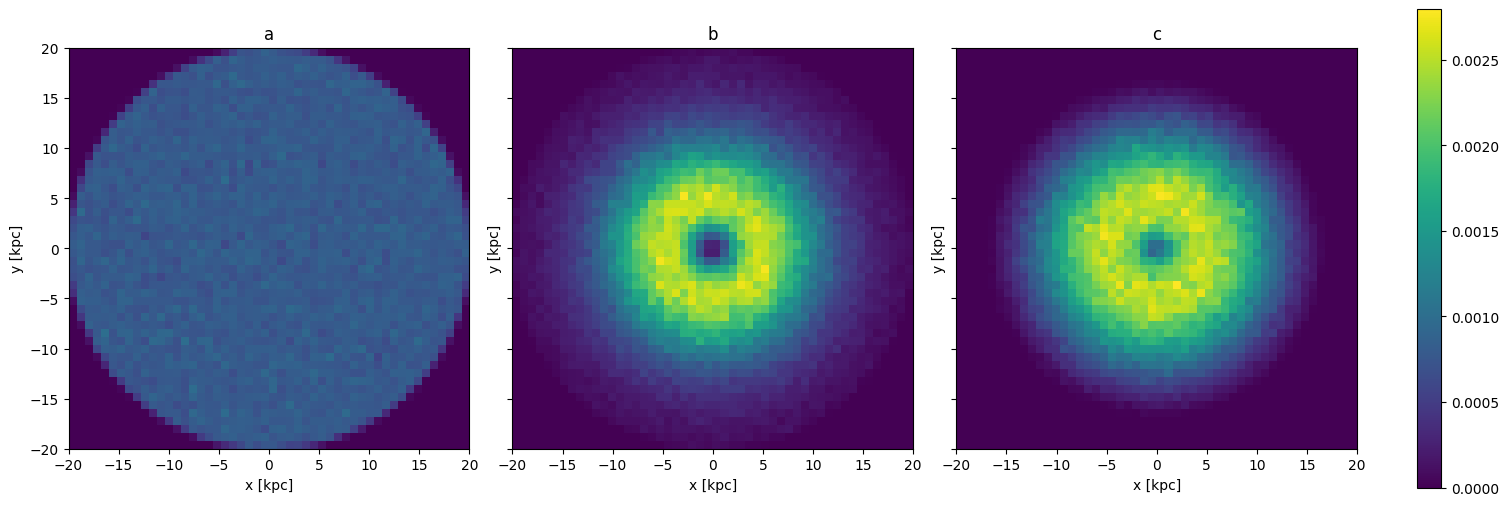

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

R_sun = 8.5
alpha = 2.0
beta_case = 3.53
R0 = 17.2
theta0 = 0.08
beta_sine = 0.13
A_case = 1.67e-3
A_sine = 1.96
R_max = 20.0
N = 300000
bins = 50

def f_uniform(R):
    return np.ones_like(R) * 2 * np.pi * R

def f_case(R):
    return A_case * (R / R_sun)**alpha * np.exp(-beta_case * (R - R_sun) / R_sun)

def f_sine(R):
    val = A_sine * np.sin(np.pi * R / R0 + theta0) * np.exp(-beta_sine * R)
    return np.where(val > 0, val * 2 * np.pi * R, 0)

def sample_from_pdf(f, R_max, N):
    R_vals = np.linspace(0.01, R_max, 2000)
    pdf = f(R_vals)
    pdf /= np.trapz(pdf, R_vals)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    u = np.random.rand(N)
    R_samples = np.interp(u, cdf, R_vals)
    theta = np.random.uniform(0, 2 * np.pi, N)
    x = R_samples * np.cos(theta)
    y = R_samples * np.sin(theta)
    return x, y

x_uniform, y_uniform = sample_from_pdf(f_uniform, R_max, N)
x_case, y_case = sample_from_pdf(lambda R: f_case(R) * 2 * np.pi * R, R_max, N)
x_sine, y_sine = sample_from_pdf(f_sine, R_max, N)

x_uniform, y_uniform = x_uniform[np.sqrt(x_uniform**2 + y_uniform**2) <= R_max], y_uniform[np.sqrt(x_uniform**2 + y_uniform**2) <= R_max]
x_case, y_case = x_case[np.sqrt(x_case**2 + y_case**2) <= R_max], y_case[np.sqrt(x_case**2 + y_case**2) <= R_max]
x_sine, y_sine = x_sine[np.sqrt(x_sine**2 + y_sine**2) <= R_max], y_sine[np.sqrt(x_sine**2 + y_sine**2) <= R_max]

hist_uniform, _, _ = np.histogram2d(x_uniform, y_uniform, bins=bins, range=[[-R_max, R_max], [-R_max, R_max]])
hist_case, xedges, yedges = np.histogram2d(x_case, y_case, bins=bins, range=[[-R_max, R_max], [-R_max, R_max]])
hist_sine, _, _ = np.histogram2d(x_sine, y_sine, bins=bins, range=[[-R_max, R_max], [-R_max, R_max]])

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
pdf_uniform = hist_uniform / (np.sum(hist_uniform) * dx * dy)
pdf_case = hist_case / (np.sum(hist_case) * dx * dy)
pdf_sine = hist_sine / (np.sum(hist_sine) * dx * dy)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True)
vmin = min(pdf_uniform.min(), pdf_case.min(), pdf_sine.min())
vmax = max(pdf_uniform.max(), pdf_case.max(), pdf_sine.max())

im0 = axs[0].imshow(pdf_uniform.T, origin='lower', extent=[-R_max, R_max, -R_max, R_max],
                    cmap='viridis', aspect='equal', vmin=vmin, vmax=vmax)
axs[0].set_title("a")
axs[0].set_xlabel("x [kpc]")
axs[0].set_ylabel("y [kpc]")

im1 = axs[1].imshow(pdf_case.T, origin='lower', extent=[-R_max, R_max, -R_max, R_max],
                    cmap='viridis', aspect='equal', vmin=vmin, vmax=vmax)
axs[1].set_title("b")
axs[1].set_xlabel("x [kpc]")
axs[1].set_ylabel("y [kpc]")

im2 = axs[2].imshow(pdf_sine.T, origin='lower', extent=[-R_max, R_max, -R_max, R_max],
                    cmap='viridis', aspect='equal', vmin=vmin, vmax=vmax)
axs[2].set_title("c")
axs[2].set_xlabel("x [kpc]")
axs[2].set_ylabel("y [kpc]")

cbar = fig.colorbar(im0, ax=axs, location='right', orientation='vertical', fraction=0.02, pad=0.04)

plt.show()

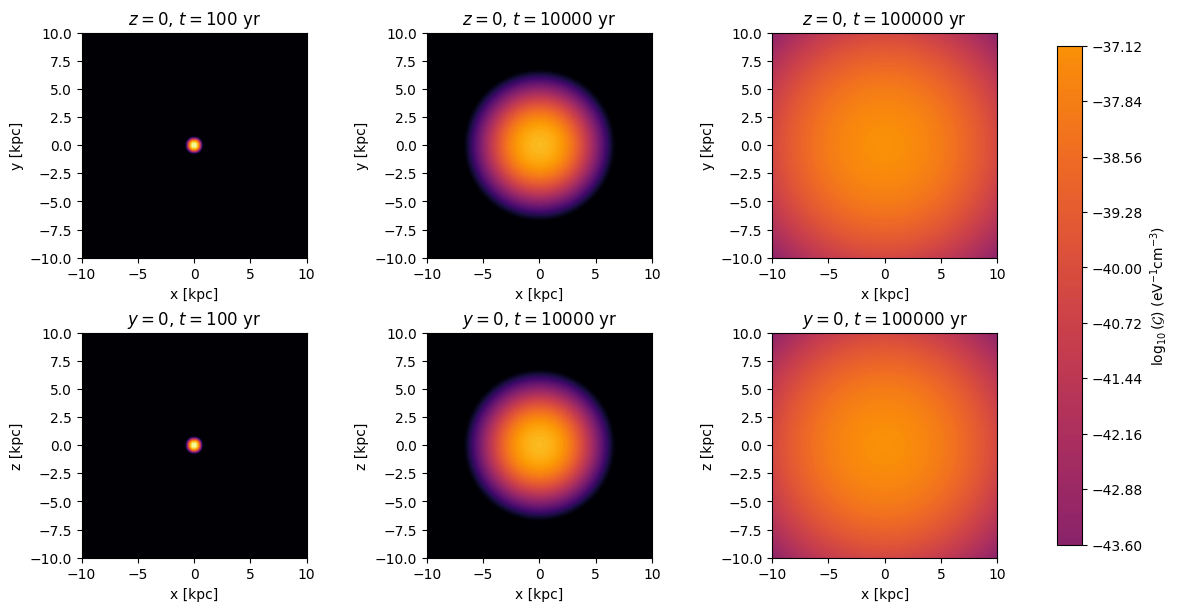

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x0, y0, z0 = 0.0, 0.0, 0.0
R = 10.0
t0 = 0.0

E = 1e15  # eV
t_values = [1e4 * val for val in [0.01, 1.0, 10.0]]

def kappa(E):
    kappa_0 = 3.3e-8  # kpc^2 / yr
    m_p_c2 = 0.938e9  # eV
    x = E / m_p_c2
    return kappa_0 * np.sqrt(np.sqrt(x**2 - 1))

def Q(E):
    alpha = 4.23
    xi_CR = 0.087
    E_SNR = 6.242e62  # eV
    m_p_c2 = 0.938e9
    Lambda = 4.111
    x = E / m_p_c2
    return (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda) * (np.sqrt(x**2 - 1)) ** (2 - alpha)

def G(E, x, y, t, z=0.0):
    D = kappa(E)
    tau = t - t0
    if tau <= 0:
        return 0.0
    r2 = (x - x0)**2 + (y - y0)**2 + (z - z0)**2
    norm = (4 * np.pi * D * 3.086e21 **2 * tau) ** (3/2)
    return Q(E) / norm * np.exp(-r2 / (4 * D * tau))

def G1(E, x, z, t, y=0.0):
    D = kappa(E)
    tau = t - t0
    if tau <= 0:
        return 0.0
    r2 = (x - x0)**2 + (y - y0)**2 + (z - z0)**2
    norm = (4 * np.pi * D * 3.086e21 **2 * tau) ** (3/2)
    return Q(E) / norm * np.exp(-r2 / (4 * D * tau))

x_vals = np.linspace(-R, R, 100)
y_vals = np.linspace(-R, R, 100)
z_vals = np.linspace(-R, R, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Xz, Z = np.meshgrid(x_vals, z_vals)

fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)

Z_all = []
Y_all = []

for t in t_values:
    Z_plane = np.array([[G(E, x, y, t, z=0.0) for x in x_vals] for y in y_vals])
    Z_log = np.log10(np.maximum(Z_plane, 1e-50))
    Z_all.append(Z_log)

for t in t_values:
    Y_plane = np.array([[G1(E, x, z, t, y=0.0) for x in x_vals] for z in z_vals])
    Y_log = np.log10(np.maximum(Y_plane, 1e-50))
    Y_all.append(Y_log)

vmin, vmax = -50, -33

for idx, Z_log in enumerate(Z_all):
    ax = axes[0, idx]
    c = ax.contourf(X, Y, Z_log, levels=100, cmap='inferno', vmin=vmin, vmax=vmax)
    ax.set_title(fr'$z=0$, $t={t_values[idx]:.0f}$ yr')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_aspect('equal')

for idx, Y_log in enumerate(Y_all):
    ax = axes[1, idx]
    c = ax.contourf(Xz, Z, Y_log, levels=100, cmap='inferno', vmin=vmin, vmax=vmax)
    ax.set_title(fr'$y=0$, $t={t_values[idx]:.0f}$ yr')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('z [kpc]')
    ax.set_aspect('equal')

cbar = fig.colorbar(c, ax=axes.ravel().tolist(), shrink=0.95, label=r'$\log_{10}(\mathcal{G})$ (eV$^{-1}$cm$^{-3}$)')

plt.show()


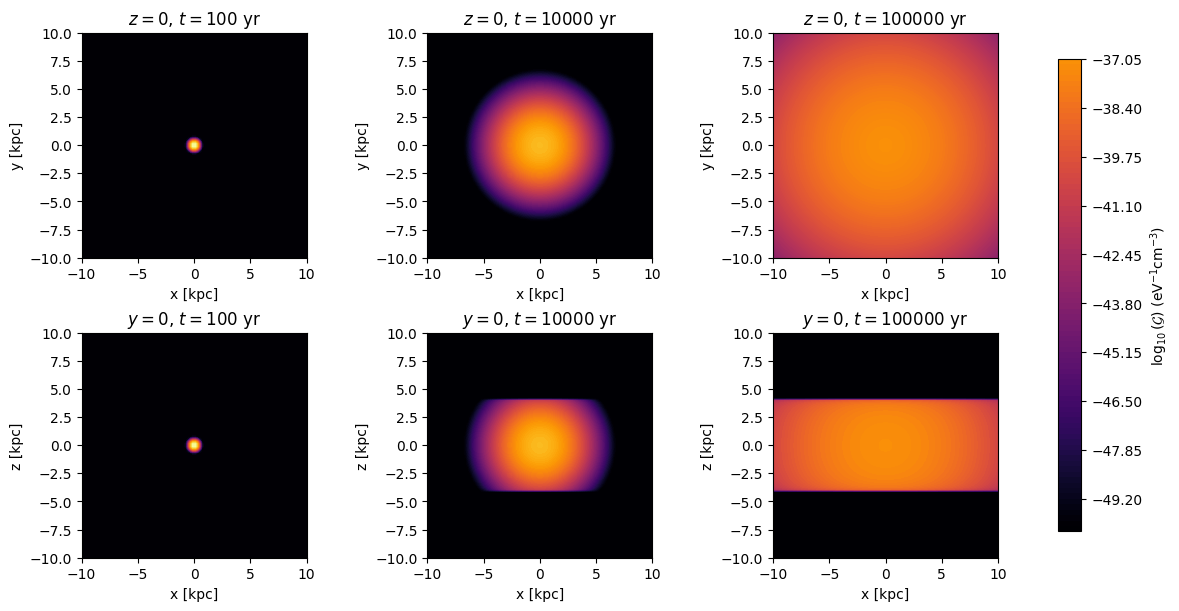

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x0, y0, z0 = 0.0, 0.0, 0.0
R = 10.0
t0 = 0.0
L = 4.0
N_images = 30

E = 1e15  # eV
t_values = [1e4 * val for val in [0.01, 1.0, 10.0]]

def kappa(E):
    kappa_0 = 3.3e-8  # kpc^2 / yr
    m_p_c2 = 0.938e9  # eV
    x = E / m_p_c2
    return kappa_0 * np.sqrt(np.sqrt(x**2 - 1))

def Q(E):
    alpha = 4.23
    xi_CR = 0.087
    E_SNR = 6.242e62  # eV
    m_p_c2 = 0.938e9
    Lambda = 4.111
    x = E / m_p_c2
    return (xi_CR * E_SNR) / (m_p_c2 ** 2 * Lambda) * (np.sqrt(x**2 - 1)) ** (2 - alpha)

def G_with_images(E, x, y, t, z=0.0):
    D = kappa(E)
    tau = t - t0
    if tau <= 0:
        return 0.0

    norm = (4 * np.pi * D * 3.086e21 **2 * tau) ** (3/2)
    sum_image = 0.0
    for n in range(-N_images, N_images + 1):
        z_image = (-1)**n * z0 + 2 * L * n
        r2 = (x - x0)**2 + (y - y0)**2 + (z - z_image)**2
        sum_image += (-1)**n * np.exp(-r2 / (4 * D * tau))

    return Q(E) / norm * sum_image

def G_with_images1(E, x, z, t, y=0.0):
    D = kappa(E)
    tau = t - t0
    if tau <= 0:
        return 0.0

    norm = (4 * np.pi * D * 3.086e21 **2 * tau) ** (3/2)
    sum_image = 0.0
    for n in range(-N_images, N_images + 1):
        z_image = (-1)**n * z0 + 2 * L * n
        r2 = (x - x0)**2 + (y - y0)**2 + (z - z_image)**2
        sum_image += (-1)**n * np.exp(-r2 / (4 * D * tau))

    return Q(E) / norm * sum_image

x_vals = np.linspace(-R, R, 100)
y_vals = np.linspace(-R, R, 100)
z_vals = np.linspace(-R, R, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Xz, Z = np.meshgrid(x_vals, z_vals)

fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)

Z_logs = []
Y_logs = []

for t in t_values:
    Z_plane = np.array([[G_with_images(E, x, y, t, z=0.0) for x in x_vals] for y in y_vals])
    Z_log = np.log10(np.maximum(Z_plane, 1e-50))
    Z_logs.append(Z_log)

    Y_plane = np.array([[G_with_images1(E, x, z, t, y=0.0) for x in x_vals] for z in z_vals])
    Y_log = np.log10(np.maximum(Y_plane, 1e-50))
    Y_logs.append(Y_log)

vmin, vmax = -50, -33

for idx, Z_log in enumerate(Z_logs):
    ax = axes[0, idx]
    c = ax.contourf(X, Y, Z_log, levels=100, cmap='inferno', vmin=vmin, vmax=vmax)
    ax.set_title(fr'$z=0$, $t={t_values[idx]:.0f}$ yr')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_aspect('equal')

for idx, Y_log in enumerate(Y_logs):
    ax = axes[1, idx]
    c = ax.contourf(Xz, Z, Y_log, levels=100, cmap='inferno', vmin=vmin, vmax=vmax)
    ax.set_title(fr'$y=0$, $t={t_values[idx]:.0f}$ yr')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('z [kpc]')
    ax.set_aspect('equal')

cbar = fig.colorbar(c, ax=axes, location='right', shrink=0.9, label=r'$\log_{10}(\mathcal{G})$ (eV$^{-1}$cm$^{-3}$)')
plt.show()
